In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
FOLDER_PREFIX = "responses"
ANALYSIS_FOLDER_PREFIX = "analysis"

In [8]:
import pandas as pd

df = pd.read_csv(f'{FOLDER_PREFIX}/all.csv')

In [9]:
# Load data/synthetic.json
if "synthetic" in FOLDER_PREFIX:
    import json
    with open(f'data/synthetic.json') as f:
        data = json.load(f)
        
    raw_df = pd.DataFrame(data)

    df = df.merge(raw_df[["id", "medications", "patient_name"]], on='id', how='left')

In [10]:
import re

def get_longest_patient_sentence(transcript):
    # Initialize variables to hold the current longest sentences and their lengths
    longest_patient_sentence = ""
    longest_patient_length = 0
    
    # Replace [patient_guest] with [patient]
    transcript = re.sub(r"\[patient_guest\]", "[patient]", transcript)

    # Split the transcript into parts, keeping the speaker tags
    parts = re.split(r"(\[doctor\]|\[patient\])", transcript)

    # Initialize a variable to remember the last speaker and a flag for short doctor interjection
    last_speaker = None
    short_doctor_interjection = False

    for part in parts:
        if part == "[doctor]":
            last_speaker = part  # Update the last speaker to doctor
            short_doctor_interjection = False  # Reset the flag for each new speaker tag
        elif part == "[patient]":
            last_speaker = part  # Update the last speaker to patient
        else:
            # Check if the last part was a short doctor interjection
            if last_speaker == "[doctor]" and len(part.split()) <= 2:
                short_doctor_interjection = True
                continue  # Skip processing this part as a separate dialogue
                
            # Split the dialogue into sentences
            sentences = re.split(r"\.|\?|\!", part)

            if not sentences:
                sentences = [part]
            
            for sentence in sentences:
                sentence = sentence.strip()
                if sentence:  # Check if the sentence is not empty
                    if (last_speaker == "[patient]" or short_doctor_interjection) and len(sentence) >= longest_patient_length:
                        longest_patient_sentence = sentence
                        longest_patient_length = len(sentence)
            # Reset the short doctor interjection flag after processing the patient part
            short_doctor_interjection = False

    if len(longest_patient_sentence) < 5:
        print(longest_patient_sentence)
        print(transcript)

    # Get starting and ending indices of the longest sentence
    patient_start = transcript.find(longest_patient_sentence)
    patient_end = patient_start + len(longest_patient_sentence)
    
    patient_idx = (patient_start + patient_end) // 2
    
    return patient_idx, longest_patient_sentence


In [11]:
question = "What is the longest sentence the patient said?"

In [12]:
# Filter df to only include rows where the question is the one we want to answer

ls_df = df[df['question'] == question]
print(len(ls_df))

86


In [13]:
# Add idx and longest sentence columns

ls_df['idx'], ls_df['longest_sentence'] = zip(*ls_df['transcript'].map(get_longest_patient_sentence))

/var/folders/nq/ldkhrrws0xb9whw7b6rpzhc00000gn/T/ipykernel_60468/419354166.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ls_df['idx'], ls_df['longest_sentence'] = zip(*ls_df['transcript'].map(get_longest_patient_sentence))
/var/folders/nq/ldkhrrws0xb9whw7b6rpzhc00000gn/T/ipykernel_60468/419354166.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ls_df['idx'], ls_df['longest_sentence'] = zip(*ls_df['transcript'].map(get_longest_patient_sentence))


In [14]:
result_cols = [
        "gemma",
        "mistral",
        "gpt4",
        "opus",
        "gpt3.5",
        "sonnet",
        "haiku",
        "gemini",
        "dbrx"
    ]

# Melt the dataframe to have a single row per model
id_vars=["id", "summary", "transcript", "idx", "longest_sentence"]
if "synthetic" in FOLDER_PREFIX:
    id_vars.remove("summary")

qa_df = pd.melt(ls_df, id_vars=id_vars, value_vars=result_cols, var_name="model", value_name="result")

In [15]:
# Compute fraction of words in the longest sentence that are in the result

def similarity(result, longest_sentence):
    if pd.isna(result):
        return 0.0
    
    # Keep only alphanumeric characters
    result = re.sub(r'[^a-zA-Z0-9\s]', '', result)
    longest_sentence = re.sub(r'[^a-zA-Z0-9\s]', '', longest_sentence)
    
    result_words = set(result.lower().split())
    longest_sentence_words = set(longest_sentence.lower().split())
    return len(result_words.intersection(longest_sentence_words)) / len(longest_sentence_words.union(result_words))

qa_df["similarity"] = qa_df.apply(lambda x: similarity(x["result"], x["longest_sentence"]), axis=1)
qa_df.head()

,id,summary,transcript,idx,longest_sentence,model,result,similarity
0,03259653f6e24c878aa1e3a9b6488d94,Patient ID: aci-D2N042-ACI071\nPatient Name: c...,[doctor] good morning carolyn how are you\n[pa...,642,no i was so initially when i first fell i was ...,gemma,"Sure, here are my answers to this query about ...",0.250000
1,0341ef9ec1f14d77b1d5940b99443029,Patient ID: aci-D2N056-ACI032\nPatient Name: n...,[patient] alright thanks for coming in today i...,4140,so i reviewed your vitals and you appear to be...,gemma,"Sure, here are my results for this transcript ...",0.121569
2,0b0f11fb206d4804b55fc334020fbecf,Patient ID: aci-D2N054-ACI102\nPatient Name: e...,[doctor] hey elijah how are you\n[patient] i'm...,878,and my other ankle too is sore sometimes and i...,gemma,"Sure, here are my answer to this query as requ...",0.160920
3,0b30252709fd4e13aba5289be5f840db,Patient ID: virtassist-D2N072-VA024\nPatient N...,"[doctor] hi , ms. brooks . i'm dr. baker . how...",440,"and as i was , um , coming down the hill , i t...",gemma,"Sure, here are my answer to this query as requ...",0.148936
4,10cc26d3967a4af0bd423663ea252d52,Patient ID: virtscribe-D2N074-VS024\nPatient N...,"[doctor] patient , bruce ward . date of birth ...",4935,yeah i never noticed that i could n't see out ...,gemma,"Sure, here are some text excerpts from this tr...",0.071429


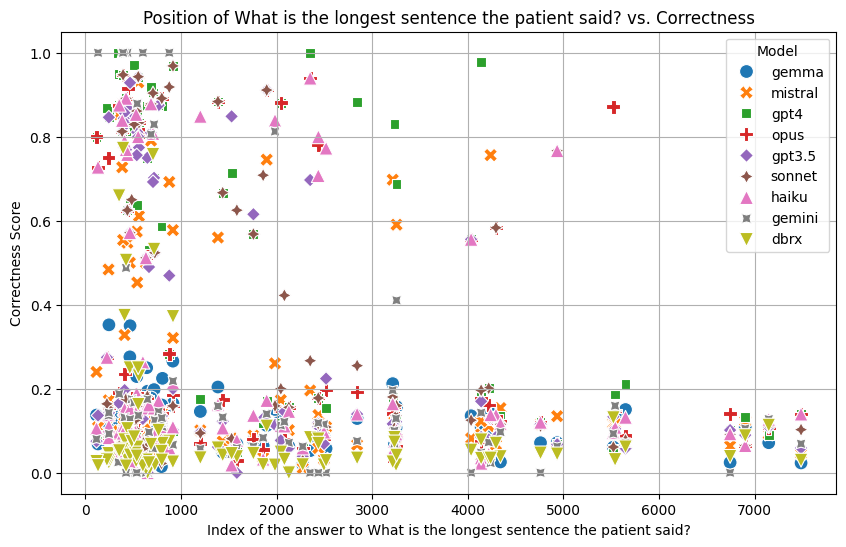

In [16]:
# Plot a heatmap of position of the longest sentence in the transcript vs similarity

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=qa_df, x='idx', y='similarity', hue='model', style='model', s=100)

plt.title(f'Position of {question} vs. Correctness')
plt.xlabel(f'Index of the answer to {question}')
plt.ylabel('Correctness Score')
plt.legend(title='Model')
plt.grid(True)
plt.show()

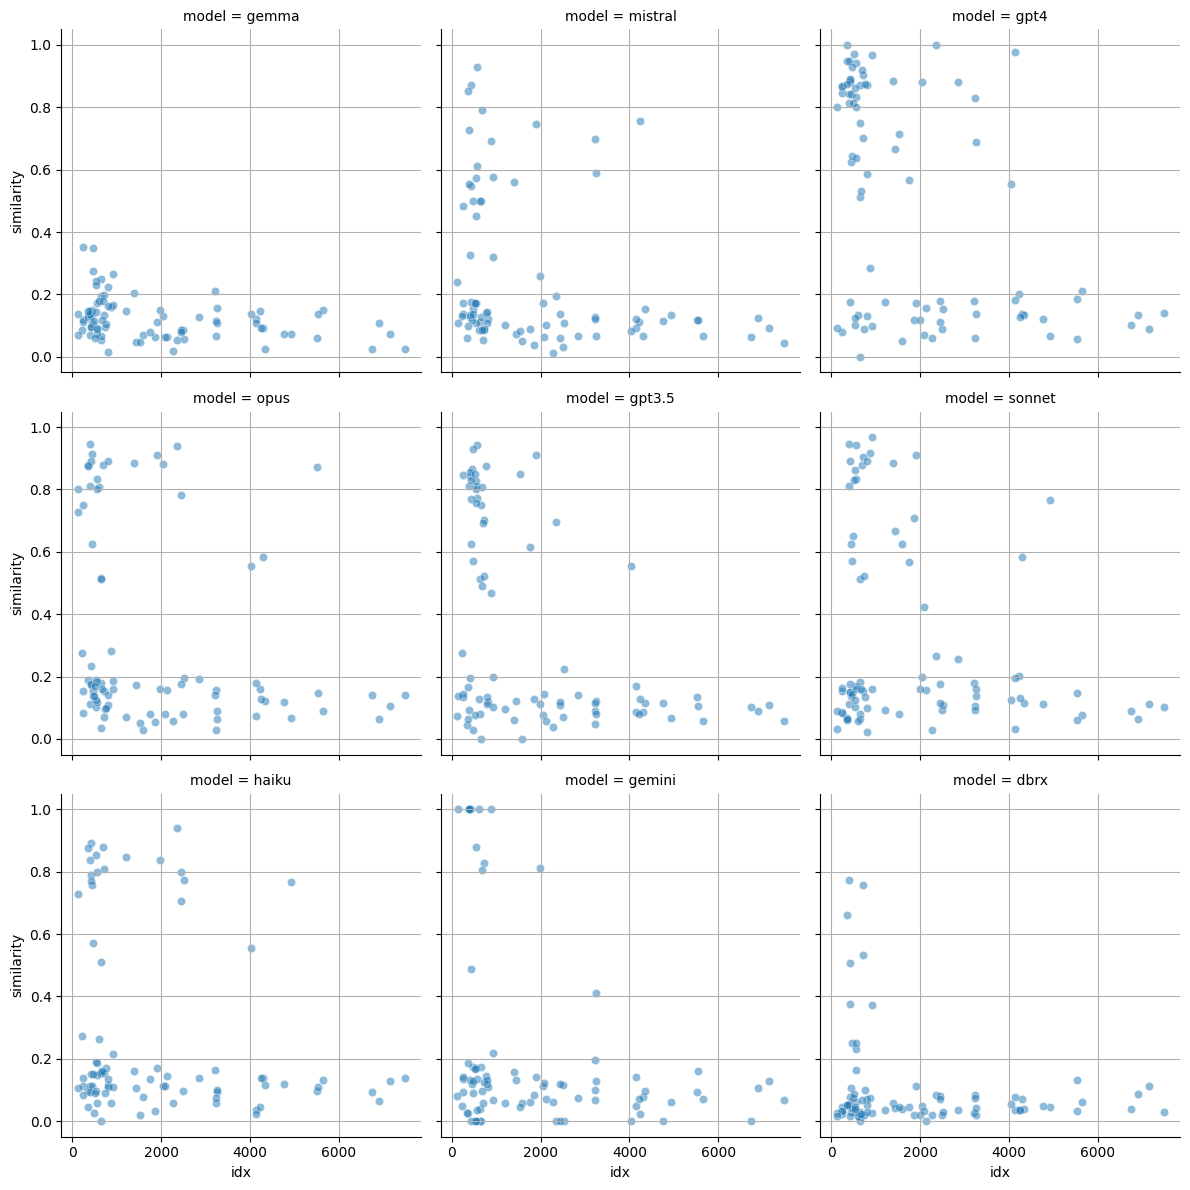

In [17]:
g = sns.FacetGrid(qa_df, col="model", col_wrap=3, height=4)
g.map(sns.scatterplot, "idx", "similarity", alpha=0.5)

# Iterate over each subplot for customization
for ax in g.axes.ravel():
    ax.grid(True)

plt.show()

/var/folders/nq/ldkhrrws0xb9whw7b6rpzhc00000gn/T/ipykernel_60468/2400337853.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/nq/ldkhrrws0xb9whw7b6rpzhc00000gn/T/ipykernel_60468/2400337853.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/nq/ldkhrrws0xb9whw7b6rpzhc00000gn/T/ipykernel_60468/2400337853.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


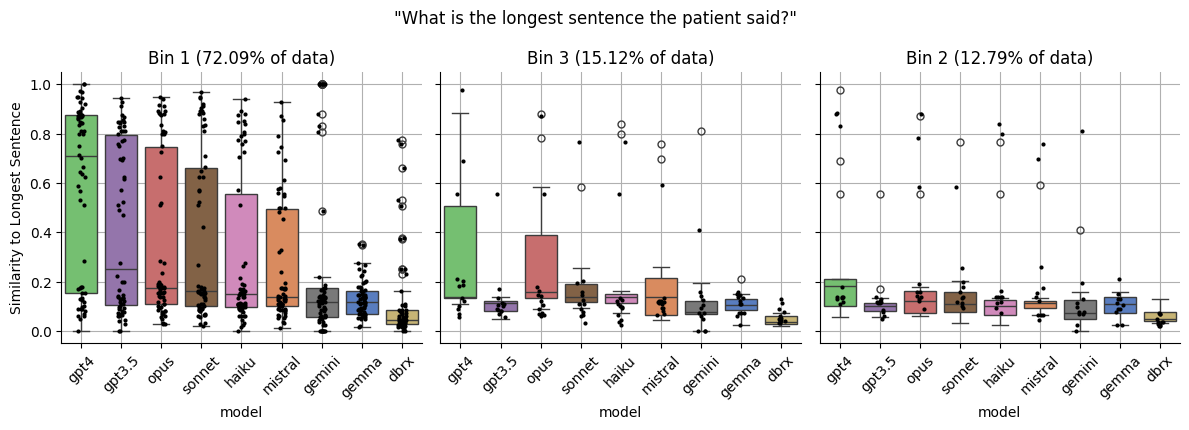

In [18]:
# Bin the indexes
n_bins = 3
qa_df["idx_as_frac"] = qa_df["idx"] / qa_df["transcript"].apply(len)
qa_df['idx_bin'] = pd.cut(qa_df['idx_as_frac'], bins=n_bins, labels=[f'Bin {i+1}' for i in range(n_bins)])

bin_counts = qa_df['idx_bin'].value_counts(normalize=True).to_dict()

# order result cols by overall mean similarity
ordered_cols = qa_df.groupby('model')['similarity'].mean().sort_values(ascending=False).index

# Create a catplot with box plots for each bin
box_g = sns.catplot(x="model", y="similarity", col="idx_bin", col_wrap=3, 
                    data=qa_df, kind="box", 
                    height=4, aspect=1, sharey=True, 
                    order=ordered_cols, palette='muted', hue='model')

# Overlay the individual points using stripplot
# Since catplot creates a FacetGrid, we can use the axes in the FacetGrid to overlay points
for ax, idx_bin in zip(box_g.axes.ravel(), qa_df['idx_bin'].unique()):
    subset = qa_df[qa_df['idx_bin'] == idx_bin]
    sns.stripplot(x="model", y="similarity", data=subset, ax=ax,
                  order=ordered_cols, color='black', size=3, jitter=True)
    ax.grid(True)
    
    ax.set_title(f'{idx_bin} ({bin_counts[idx_bin]:.2%} of data)')
    
    # Set the y-axis label
    ax.set_ylabel('Similarity to Longest Sentence')

plt.suptitle(f"\"{question}\"")

# Adjust the layout
box_g.fig.tight_layout(w_pad=1)

# Rotate the x-axis labels
for ax in box_g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

In [19]:
df.columns

Index(['question', 'id', 'summary', 'transcript', 'gemma', 'dbrx', 'haiku',
       'gemini', 'gpt4', 'opus', 'mistral', 'gpt3.5', 'sonnet'],
      dtype='object')

In [20]:
# Try another question

b_df = df[df['question'] == "What is the first name of the patient?"]

def extract_first_name(summary):
    # Find line with "Patient name: ..."
    summary_lines = summary.split('\n')
    for line in summary_lines:
        if line.startswith("Patient Name:"):
            full_name = line.split(":")[1].strip()
            
    # Get the first name
    return full_name.split()[0]

if "synthetic" in FOLDER_PREFIX:
    b_df["first_name"] = b_df["patient_name"].str.split().str[0]
else:
    b_df["first_name"] = b_df["summary"].apply(extract_first_name)

# Get rid of "nan" as first name
b_df = b_df[b_df["first_name"] != "nan"]

# Get position of first name in transcript
def get_first_name_position(transcript, first_name):
    # print(first_name)
    return transcript.lower().find(first_name.lower())

b_df["idx"] = b_df.apply(lambda x: get_first_name_position(x["transcript"], x["first_name"]), axis=1)

# Get rid of -1 as position
b_df = b_df[b_df["idx"] != -1]

# Get accuracy of models
# Melt the dataframe to have a single row per model
id_vars = ["id", "summary", "transcript", "idx", "first_name"]
if "synthetic" in FOLDER_PREFIX:
    id_vars.remove("summary")

b_melted = pd.melt(b_df, id_vars=id_vars, value_vars=result_cols, var_name="model", value_name="result")

# Compute fraction of words in the first name that are in the result
b_melted["correctness"] = b_melted.apply(lambda x: x["first_name"].lower() in str(x["result"]).lower(), axis=1).astype(int)


/var/folders/nq/ldkhrrws0xb9whw7b6rpzhc00000gn/T/ipykernel_60468/664361704.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_df["first_name"] = b_df["summary"].apply(extract_first_name)


/var/folders/nq/ldkhrrws0xb9whw7b6rpzhc00000gn/T/ipykernel_60468/4234993420.py:18: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = b_melted.pivot_table(values='correctness', index='model', columns='idx_bin', aggfunc='mean')


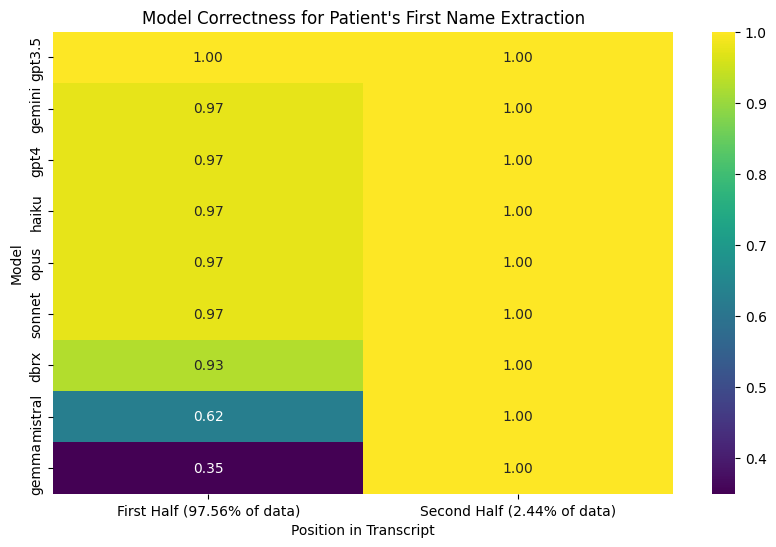

In [21]:
# Code to generate bins and ordered pivot table
n_bins = 2
b_melted['idx_bin'] = pd.cut(b_melted['idx'], bins=n_bins, labels=["First Half", "Second Half"])

# Calculate the fraction of points in each bin
bin_counts = b_melted['idx_bin'].value_counts(normalize=True)

# Sort bin_counts to match the order of bins in pivot
bin_counts = bin_counts[["First Half", "Second Half"]]  # Ensure this matches the order used in pd.cut

# Format the bin labels to include the fraction of points
bin_labels_with_counts = [f'{bin} ({count:.2%} of data)' for bin, count in bin_counts.items()]

# Order result cols by overall mean correctness
ordered_cols = b_melted.groupby('model')['correctness'].mean().sort_values(ascending=False).index

# Pivot table for the heatmap
pivot_table = b_melted.pivot_table(values='correctness', index='model', columns='idx_bin', aggfunc='mean')

# Reorder the pivot_table rows based on the ordered_cols
ordered_pivot = pivot_table.reindex(ordered_cols)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(ordered_pivot, annot=True, cmap='viridis', fmt=".2f", xticklabels=bin_labels_with_counts)
plt.title('Model Correctness for Patient\'s First Name Extraction')
plt.xlabel('Position in Transcript')
plt.ylabel('Model')
# plt.xticks(rotation=45)  # Rotate x-axis labels if needed for better readability
plt.show()

In [22]:
# Where is gpt-4 failing?

b_melted[(b_melted["model"] == "gemma") & (b_melted["correctness"] == 0)]

,id,summary,transcript,idx,first_name,model,result,correctness,idx_bin
2,10cc26d3967a4af0bd423663ea252d52,Patient ID: virtscribe-D2N074-VS024\nPatient N...,"[doctor] patient , bruce ward . date of birth ...",19,bruce,gemma,"Sure, here are answer for this query as reques...",0,First Half
3,1488167ac0834b9085a49f7904f4a6c0,Patient ID: aci-D2N057-ACI100\nPatient Name: j...,[patient] hi good afternoon joseph how are you...,28,joseph,gemma,The text does not provide any identifying info...,0,First Half
4,296b6d76803348799d7dfdb45232d548,Patient ID: aci-D2N051-ACI093\nPatient Name: j...,[doctor] hi jeremy how are you\n[patient] i'm ...,12,jeremy,gemma,"Sure, here are my answer to this query as requ...",0,First Half
5,2a98a9adef0d494791fd4b32cac618cc,Patient ID: aci-D2N039-ACI070\nPatient Name: v...,[doctor] hi virginia how are you today what br...,12,virginia,gemma,"Sure, here are my answer for this has been a l...",0,First Half
6,2b0dba06479d401ba3da45eb6cd744a7,Patient ID: aci-D2N053-ACI074\nPatient Name: b...,[doctor] so barbara i i know you are here for ...,12,barbara,gemma,The text does not disclose any personal identi...,0,First Half
7,2d6b08fc388940c895deaf151382340f,Patient ID: virtscribe-D2N026-VS032\nPatient N...,[doctor] dictating on donald clark . date of b...,22,donald,gemma,"Sure, here are answer for this questions as re...",0,First Half
9,51da7a34a5c34c1d938de7e270dfa203,Patient ID: virtscribe-D2N031-VS027\nPatient N...,"[doctor] sophia brown . date of birth , 3/17/1...",9,sophia,gemma,"Sure, here are answer for this specific query ...",0,First Half
10,53cf98618b064757a50cb4f1553d6f98,Patient ID: virtscribe-D2N027-VS016\nPatient N...,"[doctor] eugene walker , n- date of birth 4/14...",9,eugene,gemma,"Unfortunately, I do not have access nor provid...",0,First Half
12,56c6aaa6dbc741ada3cd98bf83003d04,Patient ID: virtscribe-D2N022-VS029\nPatient N...,"[doctor] this is philip gutierrez , date of bi...",17,philip,gemma,This text does not provide any specific answer...,0,First Half
13,66083c9530e04a0bb8c4aa31141742db,Patient ID: aci-D2N049-ACI048\nPatient Name: l...,[doctor] hey linda good to see you today so lo...,13,linda,gemma,"Sure, let me know if there are any other quest...",0,First Half


In [23]:
# Handle question "What medications is the patient currently taking?"

med_df = df[df['question'] == "What medications is the patient currently taking?"]

def extract_medications(summary):
    lines = summary.split('\n')
    
    in_block = False
    ret = []
    has_medications = "MEDICATIONS" in summary
    
    for line in lines:
        # Skip empty lines
        if not line.strip():
            continue
        
        if "MEDICATIONS" in line.strip():
            in_block = True
            continue
        
        if line.strip().upper() == line.strip() and in_block:
            in_block = False
            break
        
        if in_block:
            ret.append(line.strip())
            
    if has_medications and len(ret) == 0:
        assert False, f"Failed to extract medications from summary: {summary}"
            
    return "\n".join(ret) if ret else None

if "synthetic" not in FOLDER_PREFIX:
    med_df["medications"] = med_df["summary"].apply(extract_medications)
else:
    med_df["medications"] = med_df["medications"].apply(lambda x: "\n".join(x))

# Drop rows where medications are not found
med_df = med_df.dropna(subset=["medications"])

# Drop rows where "denies" is in the medications
med_df = med_df[~med_df["medications"].str.contains("denies")]

blacklist = ["patient", "taking", "medication", "reports", "daily", "dose", "mouth", "the", "no", "she", "he", "twice", "times", "using", "takes", "take", "tablet", "without", "exercise", "exercises", "consistent", "receiving", "treatment", "consisting", "needed", "applied", "topically", "mouth", "chemotherapy", "utilizes", "occasionally"]

# Get position of medications in transcript
def get_medications_position_real(transcript, medications):
    idxes = []
    
    # Iterate through all tokens in the transcript and see if the 
    # Upper case word is present in the medications
    for token in transcript.split():        
        if token.lower() in blacklist or len(token) < 5:
            continue
        
        if token.lower() in medications.lower():
            idx = transcript.lower().find(token.lower())
            idxes.append(idx)
    
    return sum(idxes) / len(idxes) if idxes else -1

def get_medications_position_synthetic(transcript, medications):
    # For each medication, find the first occurrence in the transcript
    idxes = []
    for medication in medications.split("\n"):
        if medication.lower() in transcript.lower():
            idx = transcript.lower().find(medication.lower())
            idxes.append(idx)
    
    return sum(idxes) / len(idxes) if idxes else -1

if "synthetic" not in FOLDER_PREFIX:
    med_df["idx"] = med_df.apply(lambda x: get_medications_position_real(x["transcript"], x["medications"]), axis=1)
    
else:
    med_df["idx"] = med_df.apply(lambda x: get_medications_position_synthetic(x["transcript"], x["medications"]), axis=1)

# Drop with idx = -1
print(len(med_df))
med_df = med_df[med_df["idx"] != -1]
print(len(med_df))


# Compute similarity between response and medications

def similarity(result, medications):
    
    if pd.isna(result):
        return 0.0
    
    # Only keep alphanumeric characters and spaces and forward slash
    result = re.sub(r'[^a-zA-Z0-9\s]', '', result)
    medications = re.sub(r'[^a-zA-Z0-9\s]', '', medications)
    

    medications_words = set(medications.lower().split())
    
    # Remove blacklist words
    for word in blacklist:
        if word in medications_words:
            medications_words.remove(word)
        
    
    for word in list(medications_words):
        if len(word) < 5:
            medications_words.remove(word)
            
    answer = 0
    for word in medications_words:
        if word in result.lower():
            answer += 1
            
    answer = answer / len(medications_words)
    
    # if answer == 0:
    #     print(result)
    #     print(medications_words)
    #     print()
    
    return answer

# Get accuracy of models
# Melt the dataframe to have a single row per model
id_vars = ["id", "summary", "transcript", "idx", "medications"]
if "synthetic" in FOLDER_PREFIX:
    id_vars.remove("summary")

med_melted = pd.melt(med_df, id_vars=id_vars, value_vars=result_cols, var_name="model", value_name="result")

# Compute fraction of words in the medications that are in the result
med_melted["similarity"] = med_melted.apply(lambda x: similarity(x["result"], x["medications"]), axis=1)

34
33


/var/folders/nq/ldkhrrws0xb9whw7b6rpzhc00000gn/T/ipykernel_60468/2952756688.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med_df["medications"] = med_df["summary"].apply(extract_medications)


In [24]:
med_melted.groupby('model')['similarity'].mean().sort_values(ascending=False)

model
opus       0.900505
gpt4       0.853030
haiku      0.845960
sonnet     0.835859
dbrx       0.814646
gpt3.5     0.788889
mistral    0.780303
gemini     0.726263
gemma      0.425758
Name: similarity, dtype: float64

/var/folders/nq/ldkhrrws0xb9whw7b6rpzhc00000gn/T/ipykernel_60468/996244805.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/nq/ldkhrrws0xb9whw7b6rpzhc00000gn/T/ipykernel_60468/996244805.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/nq/ldkhrrws0xb9whw7b6rpzhc00000gn/T/ipykernel_60468/996244805.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


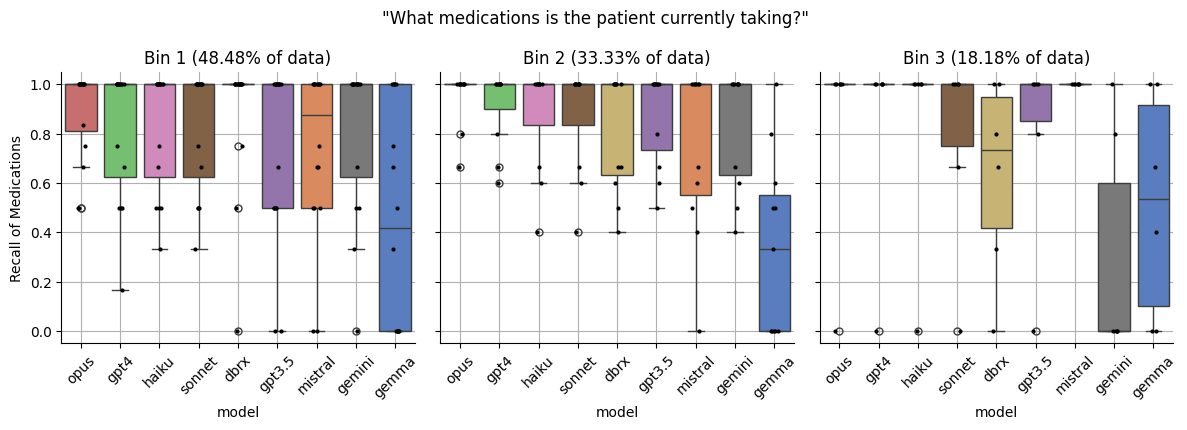

In [25]:
# Bin the indexes
n_bins = 3
med_melted["idx_as_frac"] = med_melted["idx"] / med_melted["transcript"].apply(len)
med_melted['idx_bin'] = pd.cut(med_melted['idx_as_frac'], bins=n_bins, labels=[f'Bin {i+1}' for i in range(n_bins)])

# Get value counts for bins
bin_counts = med_melted['idx_bin'].value_counts(normalize=True).to_dict()
# Multiply all values by 100
# bin_counts = {k: 100 * v for k, v in bin_counts.items()}

# order result cols by overall mean similarity
ordered_cols = med_melted.groupby('model')['similarity'].mean().sort_values(ascending=False).index

# Create a catplot with box plots for each bin
box_g = sns.catplot(x="model", y="similarity", col="idx_bin", col_wrap=3, 
                    data=med_melted, kind="box", 
                    height=4, aspect=1, sharey=True, 
                    order=ordered_cols, palette='muted', hue='model')

# Overlay the individual points using stripplot
# Since catplot creates a FacetGrid, we can use the axes in the FacetGrid to overlay points
for ax, idx_bin in zip(box_g.axes.ravel(), med_melted['idx_bin'].unique()):
    subset = med_melted[med_melted['idx_bin'] == idx_bin]
    sns.stripplot(x="model", y="similarity", data=subset, ax=ax,
                  order=ordered_cols, color='black', size=3, jitter=True)
    ax.grid(True)
    
    # Set the title
    ax.set_title(f'{idx_bin} ({bin_counts[idx_bin]:.2%} of data)')
    
    # Set the y-axis label
    ax.set_ylabel('Recall of Medications')

plt.suptitle(f"\"What medications is the patient currently taking?\"")

# Adjust the layout
box_g.fig.tight_layout(w_pad=1)

# Rotate the x-axis labels
for ax in box_g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

In [26]:
# Download the data

qa_df.to_csv(f'{ANALYSIS_FOLDER_PREFIX}/longest_patient_sentence.csv', index=False)
b_melted.to_csv(f'{ANALYSIS_FOLDER_PREFIX}/first_name.csv', index=False)
med_melted.to_csv(f'{ANALYSIS_FOLDER_PREFIX}/medications.csv', index=False)

## Synthetic eval

<Axes: >

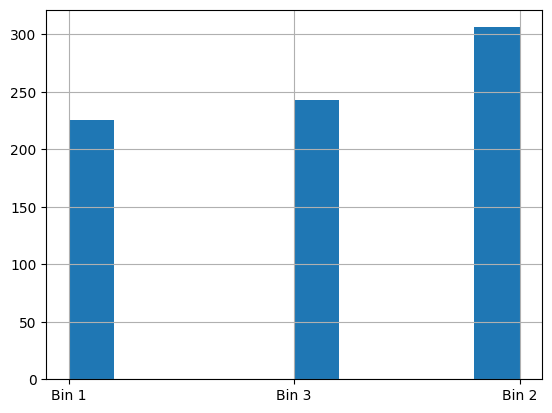

In [27]:
synthetic_df = pd.read_csv(f'{FOLDER_PREFIX}/all_synthetic.csv')
synthetic_df["needles"] = synthetic_df["needles"].apply(lambda x: eval(x))
synthetic_df["idx_as_frac"] = synthetic_df["idx"] / synthetic_df["transcript"].apply(len)


def recall_fn(result, answer):
    if pd.isna(result):
        return 0.0
    
    # see if all needles are in the haystack
    count_needles = 0
    
    for needle in answer:
        if needle.lower() in result.lower():
            count_needles += 1
            
    recall = count_needles / len(answer)
    
    return recall


# Melt the dataframe to have a single row per model
synthetic_df = pd.melt(synthetic_df, id_vars=["id", "idx", "idx_as_frac", "summary", "transcript", "needles"], value_vars=result_cols, var_name="model", value_name="result")

synthetic_df["recall"] = synthetic_df.apply(lambda x: recall_fn(x["result"], x["needles"]), axis=1)

# Bin the indexes
n_bins = 3

synthetic_df['idx_bin'] = pd.cut(synthetic_df['idx_as_frac'], bins=n_bins, labels=[f'Bin {i+1}' for i in range(n_bins)])
synthetic_df['idx_bin'].hist()

In [28]:
# Print avg recall per model

synthetic_df.groupby('model')['recall'].mean().sort_values(ascending=False)

model
gpt3.5     0.860465
gpt4       0.558140
mistral    0.337209
haiku      0.279070
opus       0.104651
sonnet     0.104651
gemma      0.089147
gemini     0.069767
dbrx       0.011628
Name: recall, dtype: float64

In [29]:
# Dump this to a csv
synthetic_df.to_csv(f'{ANALYSIS_FOLDER_PREFIX}/synthetic.csv', index=False)